In [11]:
import os
import re
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import pandas as pd
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sparta.Statistics as stat

In [200]:
# Load data for all stars by looping through the directory
delCep_results = []
wv_ranges = []
wv_ranges_size = []
pattern = re.compile(r'delCep_Hermes_spectra_(\d+)_(\d+)\.csv')
for filename in os.listdir('./delCep'):
    delCep_results.append(stat.open_csv('./delCep/'+filename))
    match = pattern.match(filename)
    if match:
        wv1, wv2 = match.groups()
        wv_range = f"{wv1}-{wv2}"
        wv_ranges.append(wv_range)
        wv_ranges_size.append(int(wv2)-int(wv1))
print(wv_ranges)
print(wv_ranges_size)

['4000-5000', '4002-4052', '4003-4953', '4007-4557', '4007-4757', '4007-4857', '4008-4808', '4011-4911', '4014-4864', '4020-4970', '4024-4374', '4025-4825', '4025-4925', '4035-4060', '4037-4337', '4038-5038', '4040-4190', '4042-4492', '4043-4643', '4045-4695', '4049-4799', '4049-4999', '4050-4950', '4054-4654', '4055-4805', '4056-4706', '4059-4959', '4064-4564', '4072-4422', '4078-4978', '4083-4933', '4085-4585', '4088-4838', '4088-5038', '4093-4893', '4099-5099', '4100-4900', '4104-4704', '4106-4406', '4106-4906', '4108-4908', '4110-5110', '4111-4511', '4111-4961', '4112-5112', '4113-4713', '4115-4765', '4117-4917', '4120-4820', '4122-4822', '4133-4683', '4134-4634', '4135-4235', '4142-4642', '4144-4244', '4147-4597', '4150-4850', '4153-4503', '4154-4854', '4155-4405', '4155-4455', '4159-4259', '4165-4315', '4165-4415', '4168-4718', '4168-4868', '4169-4969', '4174-4324', '4177-4277', '4178-5128', '4179-4529', '4182-4982', '4185-4385', '4187-4737', '4189-4939', '4190-5090', '4193-4693'

In [201]:
print(len(delCep_results))

302


In [193]:
period_truth = 5.366267

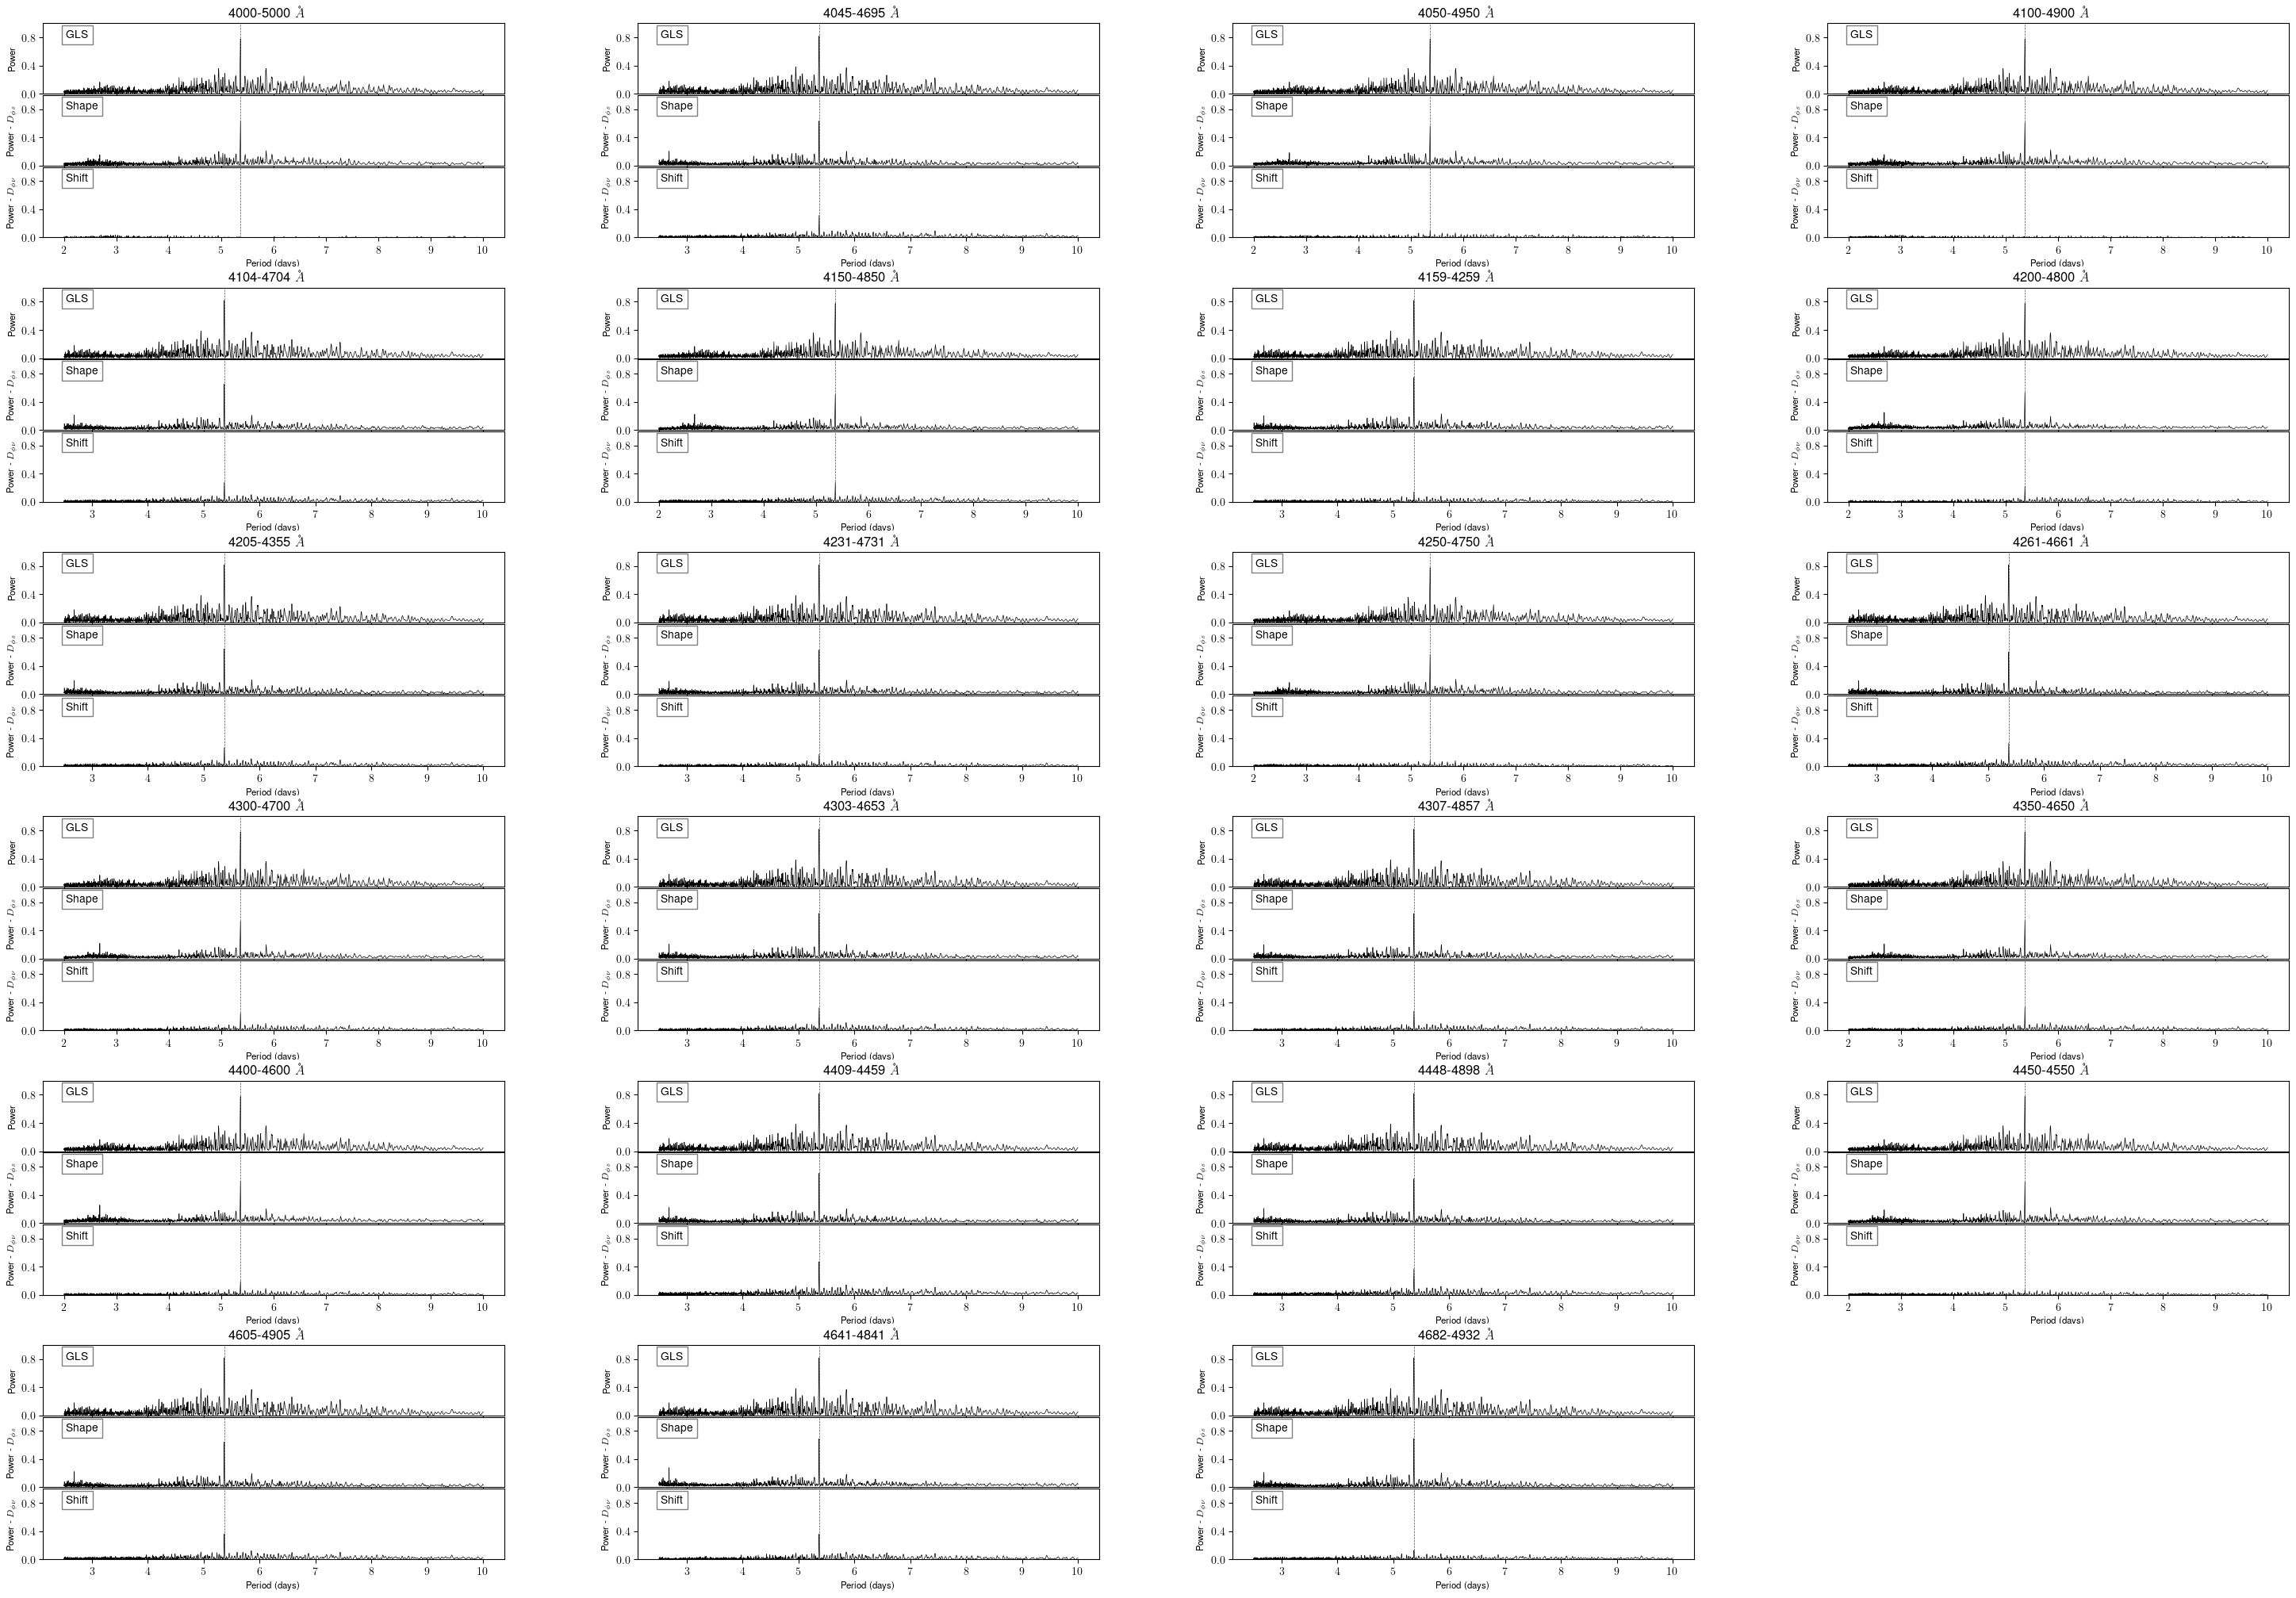

In [28]:
# Create a figure with 11 subfigures arranged in a 4*3 grid
plt.style.use('sparta')

fig = plt.figure(constrained_layout=False, figsize=(30, 20))
fig.suptitle(r'$\delta$ Cephei - Wavelength Range Analysis', fontsize='x-large')

# plt.suptitle(r'$\delta$ Cephei - Tellurics Analysis', fontsize='x-large')

subfigs = fig.subfigures(6, 4)

for outerind, subfig in enumerate(subfigs.flat):
    axs = subfig.subplots(3, 1,sharex=True)
    if outerind<=22:
        subfig.suptitle(wv_ranges[outerind]+' $\AA$')
        for innerind, ax in enumerate(axs.flat):
            if innerind==0:
                ax.plot(delCep_results[outerind]['period'], delCep_results[outerind]['gls'],linewidth=0.5)
                ax.axvline(period_truth, color='r', linestyle='--',linewidth=0.5)
                ax.set_ylabel('Power', fontsize='small')
            elif innerind==1:
                ax.plot(delCep_results[outerind]['period'], delCep_results[outerind]['shape'],linewidth=0.5)
                ax.axvline(period_truth, color='r', linestyle='--',linewidth=0.5)
                ax.set_ylabel(r'Power - $D_{\phi s}$', fontsize='small')
            elif innerind==2:
                ax.plot(delCep_results[outerind]['period'],delCep_results[outerind]['shift'],linewidth=0.5)
                ax.axvline(period_truth, color='r', linestyle='--',linewidth=0.5)
                ax.set_ylabel(r'Power - $D_{\phi \nu}$', fontsize='small')
                ax.set_xlabel('Period (days)', fontsize='small')
            # Add a small text box
            text_box = f"{['GLS', 'Shape', 'Shift'][innerind]}"
            ax.text(0.05, 0.80, text_box, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
            ax.set_ylim(0,1)
            ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
    #and recenter the last two that are not used
    else:
        for innerind, ax in enumerate(axs.flat):
            ax.axis('off')
plt.subplots_adjust(top=0.92, hspace=0.02, wspace=0.2)
plt.savefig('delCep_wv_ranges.png', dpi=450)
plt.show()

In [202]:
# find proeminences of the signal at a period of 5.366267 days

shape_proeminences = []
shift_proeminences = []
gls_proeminences = []
# print('True period is 5.366267 days')
for (idx, result),(_,wv) in zip(enumerate(delCep_results),enumerate(wv_ranges)):
    # first find the peaks for each range
    peaks_shape = find_peaks(result['shape'], distance=10)
    peaks_shift = find_peaks(result['shift'], distance=10)
    peaks_gls = find_peaks(result['gls'], distance=10)
    # compute the prominences
    shape_proeminence = peak_prominences(result['shape'], peaks_shape[0])[0]
    shift_proeminence = peak_prominences(result['shift'], peaks_shift[0])[0]
    gls_proeminence = peak_prominences(result['gls'], peaks_gls[0])[0]
    # restrain to prominence of peak closest to the truth
    shape_proeminence = shape_proeminence[np.argmin(np.abs(result['period'][peaks_shape[0]]-period_truth))]
    shape_proeminences.append(shape_proeminence)
    shift_proeminence = shift_proeminence[np.argmin(np.abs(result['period'][peaks_shift[0]]-period_truth))]
    shift_proeminences.append(shift_proeminence)
    gls_proeminence = gls_proeminence[np.argmin(np.abs(result['period'][peaks_gls[0]]-period_truth))]
    gls_proeminences.append(gls_proeminence)

In [203]:
wv_ranges_size_indices = np.argsort(wv_ranges_size)
wv_ranges_size = np.array(wv_ranges_size)[wv_ranges_size_indices]
shape_proeminences = np.array(shape_proeminences)[wv_ranges_size_indices]
shift_proeminences = np.array(shift_proeminences)[wv_ranges_size_indices]
gls_proeminences = np.array(gls_proeminences)[wv_ranges_size_indices]

In [204]:
wv_ranges_size_unique,counts = np.unique(wv_ranges_size,return_counts=True)
print(wv_ranges_size_unique)
print(counts)

[  10   15   20   25   30   35   40   45   50  100  150  200  250  300
  350  400  450  500  550  600  650  700  750  800  850  900  950 1000]
[ 2  2  2  2  1  1  1  1 15 16 14 14 14 14 14 15 14 15 14 15 14 15 14 15
 14 15 15 14]


In [205]:
# for every size, get the mean and std of the proeminences
shape_mean = []
shift_mean = []
gls_mean = []
shape_std = []
shift_std = []
gls_std = []

for size in wv_ranges_size_unique:
    shape_mean.append(np.mean(shape_proeminences[wv_ranges_size==size]))
    shift_mean.append(np.mean(shift_proeminences[wv_ranges_size==size]))
    gls_mean.append(np.mean(gls_proeminences[wv_ranges_size==size]))
    shape_std.append(np.std(shape_proeminences[wv_ranges_size==size]))
    shift_std.append(np.std(shift_proeminences[wv_ranges_size==size]))
    gls_std.append(np.std(gls_proeminences[wv_ranges_size==size]))



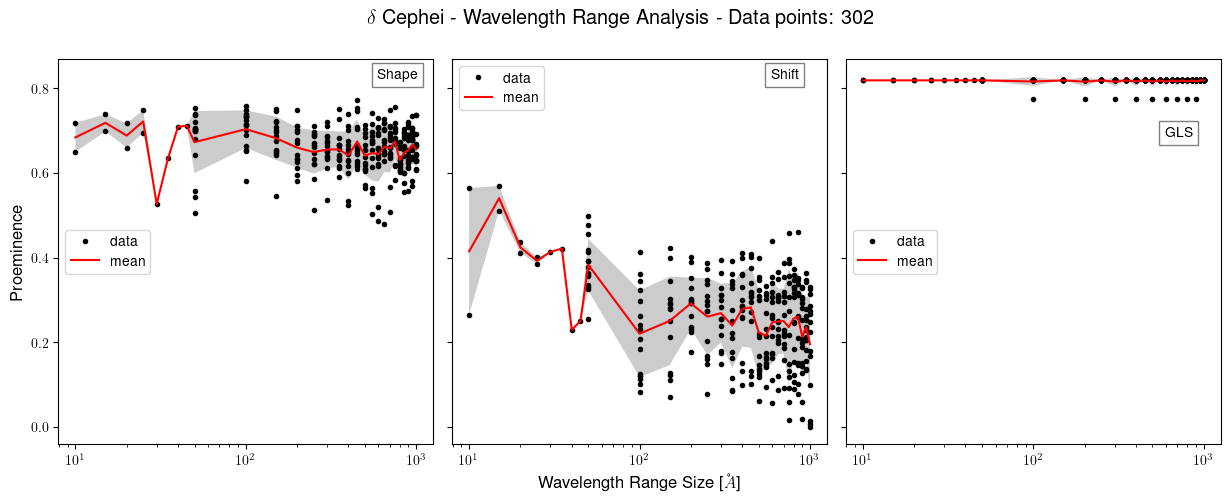

In [206]:
# plot the proeminences, put small box with shape, shift or gls
fig, ax = plt.subplots(1,3, figsize=(15,5),sharex=True,sharey=True)
plt.suptitle(r'$\delta$ Cephei - Wavelength Range Analysis - Data points: '+str(len(delCep_results)), fontsize='x-large')
ax[0].plot(wv_ranges_size, shape_proeminences, '.',label='data')
#use fill_between to plot the std
ax[0].fill_between(wv_ranges_size_unique, np.array(shape_mean)-np.array(shape_std), np.array(shape_mean)+np.array(shape_std), alpha=0.2)
ax[0].plot(wv_ranges_size_unique, shape_mean, 'r-',label='mean')
ax[0].text(0.85, 0.95, 'Shape', transform=ax[0].transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax[0].set_ylabel('Proeminence', fontsize='large')
ax[1].plot(wv_ranges_size, shift_proeminences, '.',label='data')
ax[1].plot(wv_ranges_size_unique, shift_mean, 'r-',label='mean')
ax[1].fill_between(wv_ranges_size_unique, np.array(shift_mean)-np.array(shift_std), np.array(shift_mean)+np.array(shift_std), alpha=0.2)
ax[1].text(0.85, 0.95, 'Shift', transform=ax[1].transAxes, bbox=dict(facecolor='white', alpha=0.5))
ax[1].set_xlabel('Wavelength Range Size [$\AA$]', fontsize='large')
ax[2].plot(wv_ranges_size, gls_proeminences, '.',label='data')
ax[2].plot(wv_ranges_size_unique, gls_mean, 'r-',label='mean')
ax[2].fill_between(wv_ranges_size_unique, np.array(gls_mean)-np.array(gls_std), np.array(gls_mean)+np.array(gls_std), alpha=0.2)
ax[2].text(0.85, 0.8, 'GLS', transform=ax[2].transAxes, bbox=dict(facecolor='white', alpha=0.5))
plt.subplots_adjust(wspace=0.05)
ax[0].legend(loc = 'center left')
ax[1].legend(loc='upper left')
ax[2].legend(loc = 'center left')
#put in log scale on x axis
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
# plt.savefig('delCep_wv_ranges_proeminences.png', dpi=450)
plt.show()